## Denver Bicycle Crime: Initial Exploration

#### Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

#### Acquire

In [25]:
# Check that the bicycle_theft_data.csv file exists, if not, then
# acquire and merge the individual year crime data and standardize features
# then filter the df to only bicycle theft incidents and cache the combined 
# dataframe to a CSV file.

# define name of file to be cached
cache_file = 'denver_crime_data.csv'

# check to see if cached file exists in local directory, if not acquire and cache
if not os.path.exists(cache_file):
    
    # define list of crime files from 2010-2021(most recent published) in local directory.
    crime_files = [
    'crime2010.csv', 'crime2011.csv', 'crime2012.csv', 'crime2013.csv',
    'crime2014.csv', 'crime2015.csv', 'crime2016.csv', 'crime2017.csv',
    'crime2018.csv', 'crime2019.csv', 'crime2020.csv', 'crime2021.csv']
    
    # Load previously imported Denver Crime archive files (available here: 
    # https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime)
    # Load the first file to get the column names:
    initial_df = pd.read_csv(crime_files[0])
    initial_columns = list(initial_df.columns)

    # Identify files with inconsistent column names:
    files_with_diff_columns = []
    for file in crime_files[1:]:
        df = pd.read_csv(file)
        if list(df.columns) != initial_columns:
            files_with_diff_columns.append(file)
        
    # Standardize column names. crime2020 and crime2021 have the same columns but 
    # with capitalization, but otherwise names are pythonic, so apply .lower to 
    # column names and create list of dataframes
    all_dataframes = []
    for file in crime_files:
        df = pd.read_csv(file)
        df.columns = [col.lower() for col in df.columns]
        all_dataframes.append(df)

    # Concatenate all yearly dataframes
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    # Print a statement of concatenation, shape. 
    print(f'Concatenated {len(all_dataframes)} dataframes.\nCombined dataframe \
shape is {combined_df.shape[1]} columns wide by {combined_df.shape[0]} rows long.')

    # Write combined_df to a .csv cache_file. Set index to False in order to 
    # not store an extra column 
    combined_df.to_csv(cache_file, index=False)
    
    # Print a statement of cached file creation.
    print(f'Cached combined crime data to {cache_file}')

else:
    # if cached file already exists, print results: already exists.
    print(f'{cache_file} already exists.')
    


denver_crime_data.csv already exists.


In [2]:
# # Identify files with differing columns
# files_with_diff_columns = []
# for file in crime_files:
#     df = pd.read_csv(file)
#     if set(df.columns) != initial_columns:
#         files_with_diff_columns.append(file)

# files_with_diff_columns

['crime2020.csv', 'crime2021.csv']

In [3]:
# # Display columns of the files with discrepancies
# diff_columns_data = {}
# for file in files_with_diff_columns:
#     df = pd.read_csv(file)
#     diff_columns_data[file] = list(df.columns)

# initial_columns, diff_columns_data['crime2020.csv'], diff_columns_data['crime2021.csv']

({'DISTRICT_ID',
  'FIRST_OCCURRENCE_DATE',
  'GEO_LAT',
  'GEO_LON',
  'GEO_X',
  'GEO_Y',
  'INCIDENT_ADDRESS',
  'IS_CRIME',
  'IS_TRAFFIC',
  'LAST_OCCURRENCE_DATE',
  'NEIGHBORHOOD_ID',
  'OFFENSE_CATEGORY_ID',
  'OFFENSE_CODE',
  'OFFENSE_CODE_EXTENSION',
  'OFFENSE_TYPE_ID',
  'PRECINCT_ID',
  'REPORTED_DATE',
  'VICTIM_COUNT',
  'incident_id',
  'offense_id'},
 {'district_id',
  'first_occurrence_date',
  'geo_lat',
  'geo_lon',
  'geo_x',
  'geo_y',
  'incident_address',
  'incident_id',
  'is_crime',
  'is_traffic',
  'last_occurrence_date',
  'neighborhood_id',
  'offense_category_id',
  'offense_code',
  'offense_code_extension',
  'offense_id',
  'offense_type_id',
  'precinct_id',
  'reported_date',
  'victim_count'},
 {'district_id',
  'first_occurrence_date',
  'geo_lat',
  'geo_lon',
  'geo_x',
  'geo_y',
  'incident_address',
  'incident_id',
  'is_crime',
  'is_traffic',
  'last_occurrence_date',
  'neighborhood_id',
  'offense_category_id',
  'offense_code',
  'offe

In [27]:
df_all = pd.read_csv('denver_crime_data.csv')

In [28]:
# Filter data for bicycle theft incidents
df_bike = df_all[df_all['offense_type_id'].str.contains('bicycle', case=False)]

# Extract year from the reported date
df_bike['year'] = pd.to_datetime(df_bike['reported_date']).dt.year

# Group by year and count the number of incidents
bicycle_theft_by_year = df_bike.groupby('year').size()
bicycle_theft_by_year

/var/folders/pd/dk0dsnvs72ng9hv5mkv2d0980000gn/T/ipykernel_23357/3745372371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bike['year'] = pd.to_datetime(df_bike['reported_date']).dt.year


year
2010    1349
2011    1405
2012    1681
2013    1546
2014    1438
2015    1239
2016    1694
2017    1389
2018    1546
2019    1893
2020    2062
2021    1842
2022      39
dtype: int64

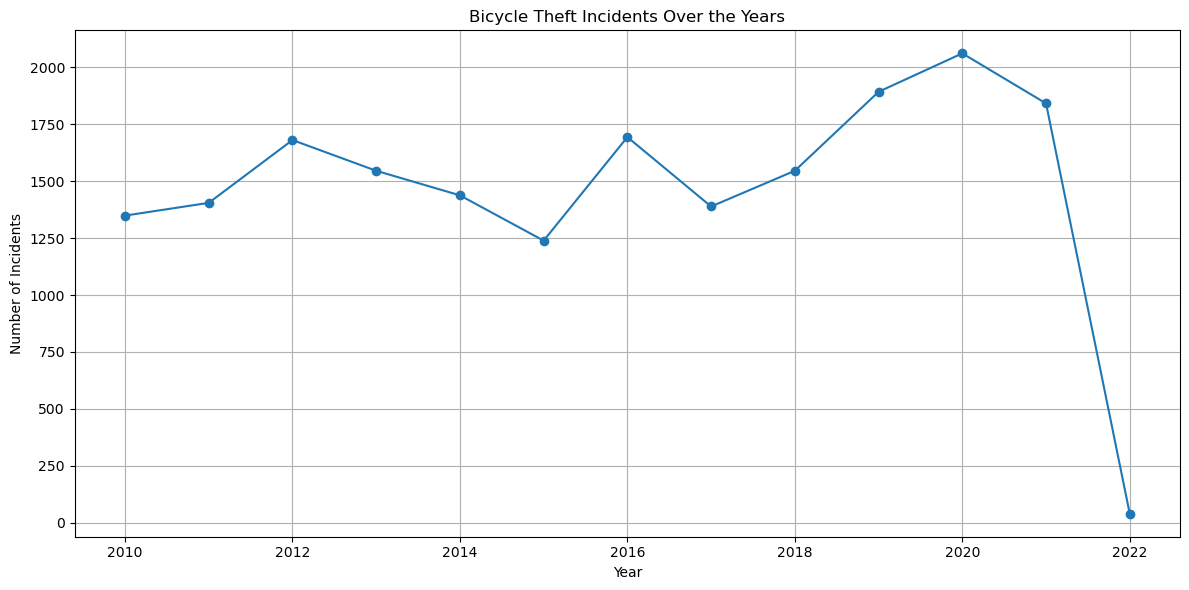

In [6]:
# Plotting the trend of bicycle theft over the years
plt.figure(figsize=(12, 6))
bicycle_theft_by_year.plot(kind='line', marker='o')
plt.title('Bicycle Theft Incidents Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Sample a subset of the data for visualization
sample_data = df_bike.sample(n=1000, random_state=42)

# Create a base map
m = folium.Map(location=[sample_data['geo_lat'].mean(), sample_data['geo_lon'].mean()], zoom_start=10)

# Add marker clusters
marker_cluster = FastMarkerCluster(data=list(zip(sample_data['geo_lat'].values, sample_data['geo_lon'].values))).add_to(m)

# Display the map
m

In [9]:
# Filter data for bicycle theft incidents
df_bike = combined_df[combined_df['offense_type_id'].str.contains('bicycle', case=False)]

# Cache the bicycle theft dataframe to a CSV file
cache_file = 'bicycle_theft_data.csv'
if not os.path.exists(cache_file):
    df_bike.to_csv(cache_file, index=False)
    print(f'Cached data to {cache_file}')
else:
    print(f'{cache_file} already exists.')

bicycle_theft_data.csv already exists.


In [10]:
import folium

In [11]:
from folium.plugins import HeatMapWithTime

# Extract year and month from the reported date using .loc to avoid the warning
df_bike.loc[:, 'year_month'] = pd.to_datetime(df_bike['reported_date']).dt.to_period('M')

# Group data by year_month
grouped = df_bike.groupby('year_month')

# Prepare data for the heatmap animation
heatmap_data = []
for name, group in grouped:
    heatmap_data.append(group[['geo_lat', 'geo_lon']].values.tolist())

# Create a base map
m = folium.Map(location=[df_bike['geo_lat'].mean(), df_bike['geo_lon'].mean()], zoom_start=10)

# Add the heatmap animation
HeatMapWithTime(heatmap_data, index=grouped.groups.keys(), radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(m)

# Display the map
m

/var/folders/pd/dk0dsnvs72ng9hv5mkv2d0980000gn/T/ipykernel_23357/1373378471.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bicycle_theft_df.loc[:, 'year_month'] = pd.to_datetime(bicycle_theft_df['reported_date']).dt.to_period('M')


In [12]:
# Create a rolling window of 5 theft events for the animation
rolling_window_data = [df_bike.iloc[i:i+5][['geo_lat', 'geo_lon']].values.tolist() for i in range(0, len(df_bike), 5)]

# Create a base map
m_rolling = folium.Map(location=[df_bike['geo_lat'].mean(), df_bike['geo_lon'].mean()], zoom_start=10)

# Add the heatmap animation with the rolling window data
HeatMapWithTime(rolling_window_data, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(m_rolling)

# Display the map
m_rolling

In [13]:
# Ensure the 'date' column is present in the dataframe
if 'date' not in df_bike.columns:
    df_bike.loc[:, 'date'] = pd.to_datetime(df_bike['reported_date']).dt.date

# Create a list of unique dates
unique_dates = df_bike['date'].unique()

# Prepare data for the heatmap animation based on daily data
daily_heatmap_data = []
for date in unique_dates:
    daily_data = df_bike[df_bike['date'] == date][['geo_lat', 'geo_lon']].values.tolist()
    daily_heatmap_data.append(daily_data)

# Create a base map
m_daily_updated = folium.Map(location=[df_bike['geo_lat'].mean(), df_bike['geo_lon'].mean()], zoom_start=10)

# Add the heatmap animation with the daily data
HeatMapWithTime(daily_heatmap_data, index=unique_dates.astype(str).tolist(), radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(m_daily_updated)

# Display the map
m_daily_updated

/var/folders/pd/dk0dsnvs72ng9hv5mkv2d0980000gn/T/ipykernel_23357/3673381320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bicycle_theft_df.loc[:, 'date'] = pd.to_datetime(bicycle_theft_df['reported_date']).dt.date
